In [1]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
import seaborn as sns

from Functions import prep_training_test_data, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data, add_labels_to_subplots
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']

# Load data

In [2]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")


Naive dataset

In [3]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

# Parameters needed for cross validation

In [9]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Functions

In [5]:
def find_net_benefit(y_probabilities, y_true, omega_sequences):   
    net_benefit_by_omega = {}
    for omega in omega_sequences:
        p = omega/(1 + omega)        
        y_predict_test = np.where(y_probabilities[:, 1] > p, 1, 0)

        tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


        net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * omega)

        net_benefit_by_omega[omega] =  net_benefit
    return net_benefit_by_omega

def get_heatmap_data_for_omega_optimal_threshold(NB_data, weeks_to_predict):
        heatmap_data_omega = pd.DataFrame()
        
        for week in range(1, weeks_to_predict[-1]):
                weekly_data = NB_data[week].values()
                #weekly_data = list(reversed(weekly_data))
                heatmap_data_omega[week] = weekly_data
        return heatmap_data_omega
def calculate_gain_data(net_benefit_naive, net_benefit_full, threshold_sequences, weeks_to_predict):
    # Get heatmap data for the naive and full periods
    heatmap_data_naive = get_heatmap_data_for_omega_optimal_threshold(net_benefit_naive, weeks_to_predict)
    heatmap_data_full = get_heatmap_data_for_omega_optimal_threshold(net_benefit_full, weeks_to_predict)
    
    # Calculate gain data
    gain_data = heatmap_data_full.subtract(heatmap_data_naive)
    
    # Add the threshold sequences as an index
    gain_data['threshold_sequences'] = threshold_sequences
    gain_data.set_index('threshold_sequences', inplace=True)
    
    return gain_data

def find_net_benefit_min_negatives(y_probabilities, y_true, omega_sequences, threshold_sequence):   
    net_benefit_by_omega = {}
    max_net_benefit = -np.inf
    for omega in omega_sequences:
        for threshold in threshold_sequence:  # You can adjust the number of threshold values
            y_predict_test = np.where(y_probabilities[:, 1] > threshold, 1, 0)

            tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


            net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * omega)

            if net_benefit > max_net_benefit:
                max_net_benefit = net_benefit
                best_threshold = threshold

        p = 1/(1 + omega)        
        y_predict_test = np.where(y_probabilities[:, 1] > p, 1, 0)

        tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


        net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)

        net_benefit_by_omega[omega] =  net_benefit
    return net_benefit_by_omega


# Calculate the net benefit at every optimal threshold 

In [7]:
omega_sequences = np.linspace(0,4,401)
threshold_sequences = []
for omega in omega_sequences:
    threshold_sequences.append((omega/(1 + omega)))
threshold_sequences = [round(threshold, 2) for threshold in threshold_sequences]


In [11]:
new_directory = '/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_exact'
os.chdir(new_directory)
net_benefit_by_omega_p_full_period = {}
net_benefit_by_model_omega_p_period_naive = {}
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

for prediction_week in weeks_to_predict:

        # Full model
        model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
        clf_full_period = pickle.load(open(model_name_to_load, 'rb'))


        X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        
        X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        weights_full_period = weights_full[0].to_numpy()

        clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full_period)

        # Make predictions on the test set
        y_pred = clf_full_period.predict(X_test_full)

        y_pred_proba = clf_full_period.predict_proba(X_test_full)
        y_pred_positive_proba = y_pred_proba[:, 1] 
        net_benefit_by_omega_week_period = find_net_benefit(y_pred_proba, y_test_full, omega_sequences)
        net_benefit_by_omega_p_full_period.__setitem__(prediction_week, net_benefit_by_omega_week_period)  


        # Naive model 
        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        
        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as is the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model

        conf_matrix = confusion_matrix(y_test_naive, y_pred)

        net_benefit_by_omega_week_shifted_naive = find_net_benefit(y_pred_proba, y_test_naive, omega_sequences)
        net_benefit_by_model_omega_p_period_naive.__setitem__(prediction_week, net_benefit_by_omega_week_shifted_naive)



/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

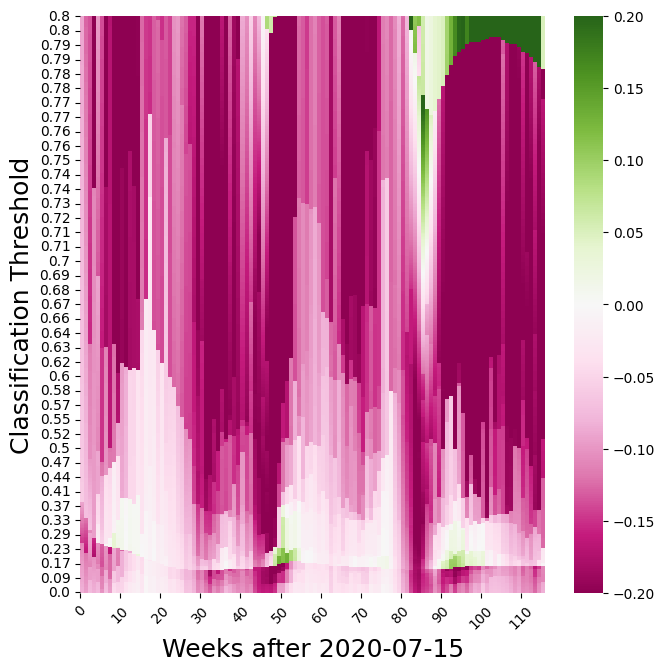

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))

gain_NB_full_vs_naive = calculate_gain_data(net_benefit_by_model_omega_p_period_naive, net_benefit_by_omega_p_full_period, threshold_sequences, weeks_to_predict)

sns.heatmap((gain_NB_full_vs_naive), annot=False, cmap='PiYG', vmin = -.2, vmax = 0.2)
ax.invert_yaxis()

ax.set_xticks(range(0, 120, 10))
x_labels = range(0, 120, 10)
ax.set_xticklabels(x_labels, rotation=45)

ax.set_xlabel('Weeks after 2020-07-15', fontsize=18)
ax.set_ylabel("Classification Threshold", fontsize=18)
plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Net_benefit_full_naive_expanding_train_models_exact_{size_of_test_dataset}_week_min_fp.png', dpi = 300)

In [30]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)

# Grid search to find optimal threshold 

In [16]:
def find_threshold_maximizing_net_benefit(y_probabilities, y_true, omega_values, threshold_sequence):
    net_benefit_values = []
    best_thresholds = []


    for omega in omega_values:
        best_threshold = None
        max_net_benefit = -np.inf

        for threshold in threshold_sequence:  # You can adjust the number of threshold values
            y_predict_test = np.where(y_probabilities[:, 1] > threshold, 1, 0)

            tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


            net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * 1/omega)

            if net_benefit > max_net_benefit:
                max_net_benefit = net_benefit
                best_threshold = threshold


        net_benefit_values.append(max_net_benefit)
        best_thresholds.append(best_threshold)

    return net_benefit_values, best_thresholds



In [17]:
net_benefit_by_omega_p_full_period_min_negative = {}
net_benefit_by_model_omega_p_period_naive_min_negative = {}
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)
weeks_to_predict = [100]
omega_sequences = np.linspace(0, 5, 100)
threshold_sequence = np.linspace(0, 1, 1000)
for prediction_week in weeks_to_predict:

        # Full model
        model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
        clf_full_period = pickle.load(open(model_name_to_load, 'rb'))


        X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        
        X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        weights_full_period = weights_full[0].to_numpy()

        clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full_period)

        # Make predictions on the test set
        y_pred = clf_full_period.predict(X_test_full)

        y_pred_proba = clf_full_period.predict_proba(X_test_full)
        y_pred_positive_proba = y_pred_proba[:, 1] 

        net_benefit_values, best_thresholds = find_threshold_maximizing_net_benefit(y_pred_proba, y_test_full, omega_sequences, threshold_sequence)
        net_benefit_by_omega_week_period = find_net_benefit(y_pred_proba, y_test_full, omega_sequences, threshold_sequence)



/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/432413421.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * 1/omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/432413421.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * 1/omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/432413421.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * 1/omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/432413421.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * 1/omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/432413421.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  net_benefit = tp/(len(y_true)) - (fp/

TypeError: find_net_benefit() takes 3 positional arguments but 4 were given

In [37]:
# Optimal threshold formula 
p_formula = []
for omega in omega_sequences:
        p_formula.append(omega/(1 + omega) )  

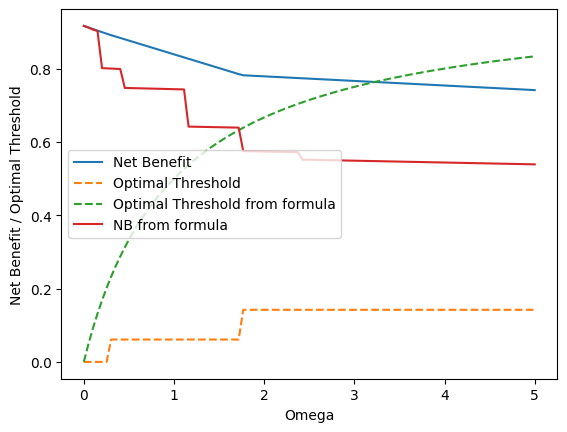

In [53]:
plt.plot(omega_sequences, net_benefit_values, label="Net Benefit")

# Plot the optimal threshold line
plt.plot(omega_sequences, best_thresholds, label="Optimal Threshold", linestyle='--')
plt.plot(omega_sequences, p_formula, label="Optimal Threshold from formula", linestyle='--')
plt.plot(omega_sequences, net_benefit_by_omega_week_period_naive.values(), label="NB from formula")

plt.xlabel("Omega")
plt.ylabel("Net Benefit / Optimal Threshold")
plt.legend()
plt.show()

# Integreate new way into the function

In [18]:
omega_sequences = np.linspace(0,10,401)
threshold_sequence = np.linspace(0,1,101)


In [20]:
def find_net_benefit_min_negatives(y_probabilities, y_true, omega_sequences, threshold_sequence):   
    net_benefit_by_omega = {}
    optimal_threshold_by_omega = {}

    for omega in omega_sequences:
        best_threshold = None
        max_net_benefit = -np.inf

        for threshold in threshold_sequence:  # You can adjust the number of threshold values
            y_predict_test = np.where(y_probabilities[:, 1] > threshold, 1, 0)

            tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


            net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)

            if net_benefit > max_net_benefit:
                max_net_benefit = net_benefit
                best_threshold = threshold


        net_benefit_by_omega[omega] =  max_net_benefit
        optimal_threshold_by_omega[omega] =  best_threshold

    return net_benefit_by_omega, optimal_threshold_by_omega


In [21]:
def find_net_benefit(y_probabilities, y_true, omega_sequences, threshold_sequence):   
    net_benefit_by_omega = {}
    optimal_threshold_by_omega = {}

    for omega in omega_sequences:
        best_threshold = None
        max_net_benefit = -np.inf

        for threshold in threshold_sequence:  # You can adjust the number of threshold values
            y_predict_test = np.where(y_probabilities[:, 1] > threshold, 1, 0)

            tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


            net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * omega)

            if net_benefit > max_net_benefit:
                max_net_benefit = net_benefit
                best_threshold = threshold


        net_benefit_by_omega[omega] =  max_net_benefit
        optimal_threshold_by_omega[omega] =  best_threshold

    return net_benefit_by_omega, optimal_threshold_by_omega

In [22]:
def find_net_benefit_balance_all(y_probabilities, y_true, omega_sequences, threshold_sequence):   
    net_benefit_by_omega = {}
    optimal_threshold_by_omega = {}
    tp_by_omega = {}
    fp_by_omega = {}
    tn_by_omega = {}
    fn_by_omega = {}
    for omega in omega_sequences:
        best_threshold = None
        max_net_benefit = -np.inf

        for threshold in threshold_sequence:  # You can adjust the number of threshold values
            y_predict_test = np.where(y_probabilities[:, 1] > threshold, 1, 0)

            tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


            net_benefit = ((tp/(len(y_true))) - (fn/(len(y_true)))) -  omega*((fp/(len(y_true))) - (tn/(len(y_true))))

            if net_benefit > max_net_benefit:
                max_net_benefit = net_benefit
                best_threshold = threshold
                final_tp = tp 
                final_fp = fp 
                final_tn = tn
                final_fn = fn

        tp_by_omega[omega] = final_tp
        fp_by_omega[omega] = final_fp
        tn_by_omega[omega] = final_tn
        fn_by_omega[omega] = final_fn
        net_benefit_by_omega[omega] =  max_net_benefit
        optimal_threshold_by_omega[omega] =  best_threshold

    return net_benefit_by_omega, optimal_threshold_by_omega, tp_by_omega, fp_by_omega, tn_by_omega, fn_by_omega

In [24]:
net_benefit_by_omega_p_full_period = {}
threshold_by_omega_p_full_period = {}

net_benefit_by_model_omega_p_period_naive = {}
threshold_by_model_omega_p_period_naive = {}


net_benefit_by_omega_p_full_period_min_negative = {}
threshold_by_omega_p_full_period_min_negative = {}

net_benefit_by_model_omega_p_period_naive_min_negative = {}
threshold_by_model_omega_p_period_naive_min_negative = {}

net_benefit_by_omega_p_full_period_combined = {}
threshold_by_omega_p_full_period_min_combined = {}

net_benefit_by_model_omega_p_period_naive_combined = {}
threshold_by_model_omega_p_period_naive_combined = {}
tp_omega_p_period_naive_combined = {}
fp_omega_p_period_naive_combined = {}
tn_omega_p_period_naive_combined = {}
fn_omega_p_period_naive_combined = {}

tp_omega_p_naive_combined = {}
fp_omega_p_naive_combined = {}
tn_omega_p_naive_combined = {}
fn_omega_p_naive_combined = {}

weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

for prediction_week in weeks_to_predict:
        print(prediction_week)
        # Full model
        model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
        clf_full_period = pickle.load(open(model_name_to_load, 'rb'))


        X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        
        X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        weights_full_period = weights_full[0].to_numpy()

        clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full_period)

        # Make predictions on the test set
        y_pred = clf_full_period.predict(X_test_full)

        y_pred_proba = clf_full_period.predict_proba(X_test_full)
        net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit(y_pred_proba, y_test_full, omega_sequences, threshold_sequence)
        net_benefit_by_omega_p_full_period.__setitem__(prediction_week, net_benefit_by_omega_week_period)  
        threshold_by_omega_p_full_period.__setitem__(prediction_week, optimal_threshold_by_omega)  
        net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
        net_benefit_by_omega_p_full_period_min_negative.__setitem__(prediction_week, net_benefit_by_omega_week_period)  
        
        net_benefit_by_omega_week_period, optimal_threshold_by_omega, tp_by_omega, fp_by_omega, tn_by_omega, fn_by_omega = find_net_benefit_balance_all(y_pred_proba, y_test_full, omega_sequences, threshold_sequence)
        net_benefit_by_omega_p_full_period_combined.__setitem__(prediction_week, net_benefit_by_omega_week_period)
        tp_omega_p_period_naive_combined.__setitem__(prediction_week, tp_by_omega)
        fp_omega_p_period_naive_combined.__setitem__(prediction_week, fp_by_omega)
        tn_omega_p_period_naive_combined.__setitem__(prediction_week, tn_by_omega)
        fn_omega_p_period_naive_combined.__setitem__(prediction_week, fn_by_omega)


        # Naive model 
        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        
        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as is the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model

        net_benefit_by_omega_week_period_naive, optimal_threshold_by_omega = find_net_benefit(y_pred_proba, y_test_naive, omega_sequences, threshold_sequence)
        net_benefit_by_model_omega_p_period_naive.__setitem__(prediction_week, net_benefit_by_omega_week_period_naive)
        threshold_by_model_omega_p_period_naive.__setitem__(prediction_week, optimal_threshold_by_omega)

        net_benefit_by_omega_week_period_naive, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_naive, omega_sequences, threshold_sequence)
        net_benefit_by_model_omega_p_period_naive_min_negative.__setitem__(prediction_week, net_benefit_by_omega_week_period_naive)

        net_benefit_by_omega_week_period_naive, optimal_threshold_by_omega, tp_by_omega, fp_by_omega, tn_by_omega, fn_by_omega= find_net_benefit_balance_all(y_pred_proba, y_test_naive, omega_sequences, threshold_sequence)
        net_benefit_by_model_omega_p_period_naive_combined.__setitem__(prediction_week, net_benefit_by_omega_week_period_naive)

        tp_omega_p_naive_combined.__setitem__(prediction_week, tp_by_omega)
        fp_omega_p_naive_combined.__setitem__(prediction_week, fp_by_omega)
        tn_omega_p_naive_combined.__setitem__(prediction_week, tn_by_omega)
        fn_omega_p_naive_combined.__setitem__(prediction_week, fn_by_omega)

1


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

2


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

3


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

4


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

5


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

6


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)


7


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

8


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

9


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

10


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

11


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

12


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

13


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

14


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

15


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

16


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

17


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

18


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

19


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

20


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

21


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

22


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

23


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

24


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

25


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

26


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

27


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

28


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

29


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

30


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

31


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

32


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

33


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

34


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

35


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

36


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

37


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

38


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

39


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

40


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

41


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

42


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

43


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

44


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

45


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

46


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

47


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

48


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

49


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

50


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

51


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

52


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

53


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

54


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

55


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

56


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

57


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

58


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

59


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

60


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

61


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

62


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

63


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

64


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

65


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

66


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

67


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

68


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

69


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

70


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

71


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

72


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

73


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

74


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

75


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

76


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

77


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

78


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

79


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

80


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

81


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

82


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

83


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

84


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

85


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

86


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

87


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

88


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

89


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

90


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

91


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

92


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

93


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

94


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

95


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

96


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

97


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

98


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

99


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

100


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

101


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

102


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

103


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

104


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

105


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

106


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

107


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

108


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

109


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

110


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

111


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

112


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

113


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

114


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

115


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

116


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

117


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/2077463858.py:52: RuntimeWarning: divide by zero encountered in divide
  net_benefit_by_omega_week_period, optimal_threshold_by_omega = find_net_benefit_min_negatives(y_pred_proba, y_test_full, 1/omega_sequences, threshold_sequence)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1058678223.py:15: Runtim

In [25]:
net_benefit_by_omega_p_full_period_min_negative_flipped = get_heatmap_data_for_omega_optimal_threshold(net_benefit_by_omega_p_full_period_min_negative, weeks_to_predict)
net_benefit_by_omega_p_full_period_flipped = get_heatmap_data_for_omega_optimal_threshold(net_benefit_by_omega_p_full_period, weeks_to_predict)

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data


<Axes: >

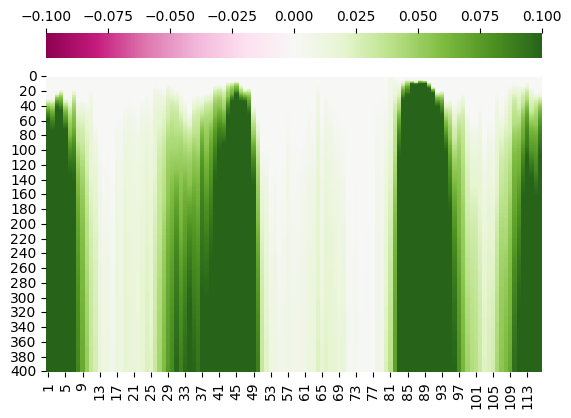

In [26]:
sns.heatmap(net_benefit_by_omega_p_full_period_min_negative_flipped, annot=False, cmap='PiYG', cbar_kws = dict(use_gridspec=True,location="top"))


In [28]:
y_ticks = range(0, 401, 40)
axes[0].set_yticks(y_ticks)  # Set the positions
y_labels = [threshold_sequences[y] for y in y_ticks]

NameError: name 'axes' is not defined

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

TypeError: Colorbar.__init__() got an unexpected keyword argument 'vmin'

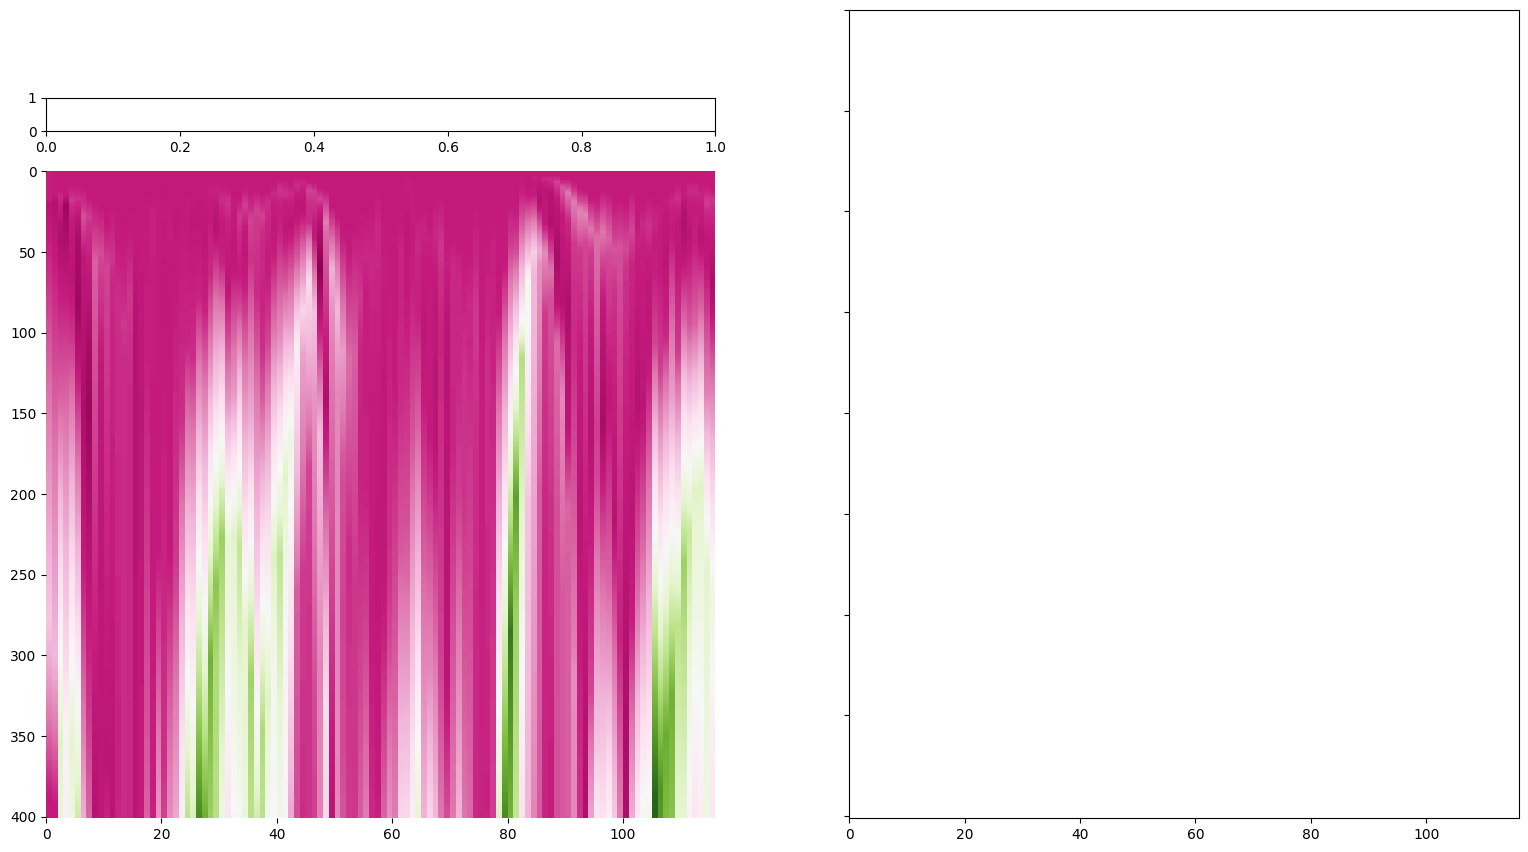

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(19, 10.5), sharey = 'all', sharex = 'all')
axes.ravel()
gain_NB_full_vs_naive = calculate_gain_data(net_benefit_by_model_omega_p_period_naive, net_benefit_by_omega_p_full_period, omega_sequences, weeks_to_predict)
gain_NB_full_vs_naive_min_negative = calculate_gain_data(net_benefit_by_model_omega_p_period_naive_min_negative, net_benefit_by_omega_p_full_period_min_negative, omega_sequences, weeks_to_predict)


sns.heatmap(gain_NB_full_vs_naive, annot=False, cmap='PiYG', ax = axes[0], cbar_kws = dict(use_gridspec=True,location="top", vmin=-0.5, vmax=0.5))
axes[0].invert_yaxis()
ax2 = axes[0].twinx()
sns.lineplot(x=weeks_to_predict, y=percent_exceed_capacity[0:len(weeks_to_predict)], ax=ax2,  color = 'black', linestyle = '--')
ax2.set_ylabel('Percent exceeding hospital capacity', fontsize=14, **hfont)

sns.heatmap(gain_NB_full_vs_naive_min_negative, annot=False, cmap='PiYG',  ax = axes[1], cbar_kws = dict(use_gridspec=True,location="top",  vmin=-0.5, vmax=0.5))
axes[1].invert_yaxis()
ax2 = axes[1].twinx()

sns.lineplot(x=weeks_to_predict, y=percent_exceed_capacity[0:len(weeks_to_predict)], ax=ax2,  color = 'black', linestyle = '--')
ax2.set_ylabel('Percent exceeding hospital capacity', fontsize=14, **hfont)

#y_ticks = range(0, 401, 40)
axes[0].set_yticks(y_ticks)  # Set the positions
y_labels = [omega_sequences[y] for y in y_ticks]
y_labels = [round(label, 2) for label in y_labels]
axes[0].set_yticklabels(y_labels,fontsize=14, **hfont)  # Set the labels

axes[0].set_xticks(range(0, 120, 10))
x_labels = range(0, 120, 10)
axes[0].set_xticklabels(x_labels, rotation=45, fontsize=14, **hfont)
axes[1].set_xticks(range(0, 120, 10))
x_labels = range(0, 120, 10)
axes[1].set_xticklabels(x_labels, rotation=45, fontsize=14, **hfont)

axes[0].set_xlabel('Weeks after 2020-07-15', fontsize=18, **hfont)
axes[1].set_xlabel('Weeks after 2020-07-15', fontsize=18, **hfont)
axes[0].set_ylabel("Penalty ", fontsize=18, **hfont)
axes[1].set_ylabel("Penalty ", fontsize=18, **hfont)
add_labels_to_subplots(axes, hfont, 1.01, 24);

plt.tight_layout()
add_labels_to_subplots(axes, hfont, 1.01, 24);
#plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Net_benefit_full_naive_expanding_train_models_period_{size_of_test_dataset}_week_min_fp_fn_grid_search.png', dpi = 300)

Combined metric

In [30]:
net_benefit_by_omega_p_full_period_combined_flipped = get_heatmap_data_for_omega_optimal_threshold(net_benefit_by_omega_p_full_period_combined, weeks_to_predict)


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_17196/1789392147.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1396/1789392147.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

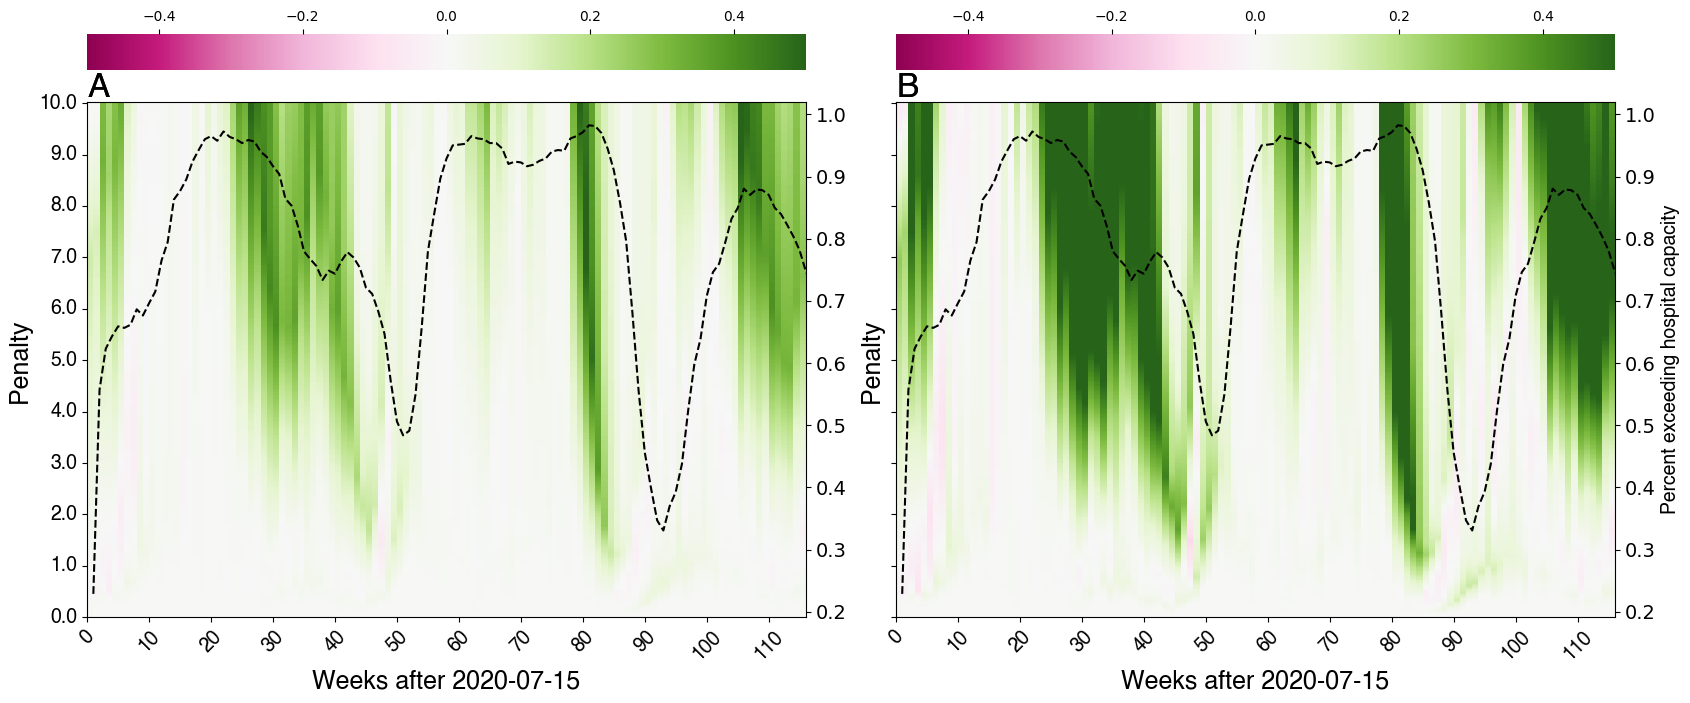

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(17, 7.5), sharey = 'all', sharex = 'all')
axes.ravel()
gain_NB_full_vs_naive_combined = calculate_gain_data(net_benefit_by_model_omega_p_period_naive_combined, net_benefit_by_omega_p_full_period_combined, omega_sequences, weeks_to_predict)


sns.heatmap(gain_NB_full_vs_naive, annot=False, cmap='PiYG', ax = axes[0], cbar_kws = dict(use_gridspec=True,location="top"), vmin=-0.5, vmax=0.5)
axes[0].invert_yaxis()
ax2 = axes[0].twinx()
sns.lineplot(x=weeks_to_predict, y=percent_exceed_capacity[0:len(weeks_to_predict)], ax=ax2,  color = 'black', linestyle = '--')
#ax2.set_ylabel('Percent exceeding hospital capacity', fontsize=14, **hfont)
ax2.tick_params(axis='y', which='major', labelsize=14)

sns.heatmap(gain_NB_full_vs_naive_combined, annot=False, cmap='PiYG',  ax = axes[1], cbar_kws = dict(use_gridspec=True,location="top"), vmin=-0.5, vmax=0.5)
axes[1].invert_yaxis()
ax2 = axes[1].twinx()

sns.lineplot(x=weeks_to_predict, y=percent_exceed_capacity[0:len(weeks_to_predict)], ax=ax2,  color = 'black', linestyle = '--')
ax2.set_ylabel('Percent exceeding hospital capacity', fontsize=14, **hfont)

y_ticks = range(0, 401, 40)
axes[0].set_yticks(y_ticks)  # Set the positions
y_labels = [omega_sequences[y] for y in y_ticks]
y_labels = [round(label, 2) for label in y_labels]
axes[0].set_yticklabels(y_labels,fontsize=14, **hfont)  # Set the labels

axes[0].set_xticks(range(0, 120, 10))
x_labels = range(0, 120, 10)
axes[0].set_xticklabels(x_labels, rotation=45, fontsize=14, **hfont)
axes[1].set_xticks(range(0, 120, 10))
x_labels = range(0, 120, 10)
axes[1].set_xticklabels(x_labels, rotation=45, fontsize=14, **hfont)

axes[0].set_xlabel('Weeks after 2020-07-15', fontsize=18, **hfont)
axes[1].set_xlabel('Weeks after 2020-07-15', fontsize=18, **hfont)
axes[0].set_ylabel("Penalty ", fontsize=18, **hfont)
axes[1].set_ylabel("Penalty ", fontsize=18, **hfont)
add_labels_to_subplots(axes, hfont, 1.01, 24);
ax2.tick_params(axis='y', which='major', labelsize=14)

plt.tight_layout()
add_labels_to_subplots(axes, hfont, 1.01, 24);
plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Net_benefit_full_naive_expanding_train_models_exact_{size_of_test_dataset}_week_NB_combined_NB_grid_search.png', dpi = 300)

In [29]:
gain_NB_full_vs_naive_combined.to_csv('/Users/rem76/Documents/COVID_projections/Exact_analysis/gain_NB_full_vs_naive_combined.csv')
gain_NB_full_vs_naive.to_csv('/Users/rem76/Documents/COVID_projections/Exact_analysis/gain_NB_full_vs_naive.csv')